Importamos las librerias necesarias para el proyecto

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, train_test_split, GridSearchCV, RandomizedSearchCV
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier
from sklearn.metrics import classification_report, accuracy_score, mean_squared_error, r2_score, mean_absolute_error, confusion_matrix
from pycaret.classification import setup, compare_models, create_model, tune_model, evaluate_model, predict_model
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from scipy.stats import randint
from prophet import Prophet
import itertools
import joblib
import warnings


Cargamos los datos del proyecto

In [2]:
demand_data = pd.read_csv(r'C:\Users\aruiz73\OneDrive - Cementos Argos S.A\Escritorio\Profesional ML\prueba_tecnica\Data\input\dataset_demand_acumulate.csv', parse_dates=['year_month'], index_col='year_month')
alpha_beta_data = pd.read_csv(r'C:\Users\aruiz73\OneDrive - Cementos Argos S.A\Escritorio\Profesional ML\prueba_tecnica\Data\input\dataset_alpha_betha.csv')
to_predict_data = pd.read_csv(r'C:\Users\aruiz73\OneDrive - Cementos Argos S.A\Escritorio\Profesional ML\prueba_tecnica\Data\input\to_predict.csv')
print(demand_data.columns)
print(demand_data.head)
print(demand_data.describe())

Index(['Demand'], dtype='object')
<bound method NDFrame.head of                  Demand
year_month             
2017-01-01  1211.009490
2017-02-01  1660.584649
2017-03-01  3182.587014
2017-04-01  3506.515270
2017-05-01  4554.082280
...                 ...
2021-12-01  3006.311107
2022-01-01   217.314949
2022-02-01   332.062614
2022-03-01   609.119726
2022-04-01  1048.486287

[64 rows x 1 columns]>
            Demand
count    64.000000
mean   2600.044986
std    1943.995938
min     217.314949
25%    1034.370651
50%    1947.817229
75%    4216.465081
max    7686.307292


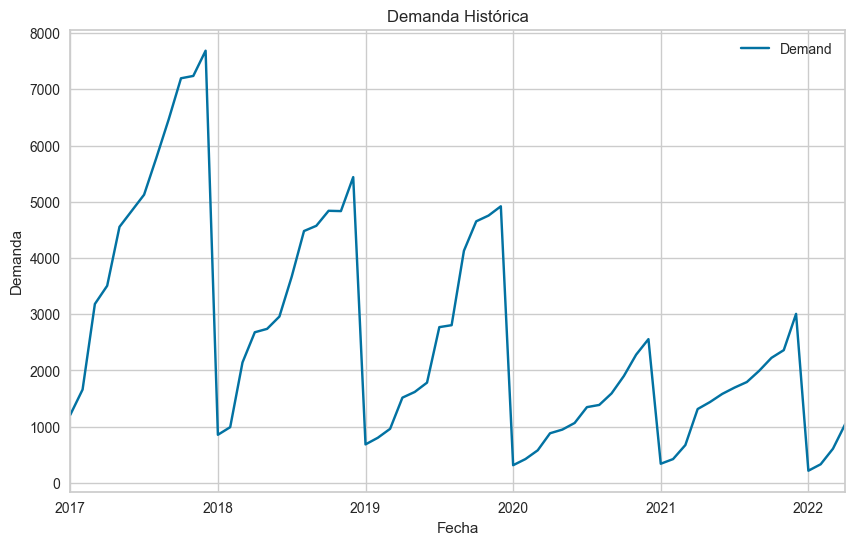

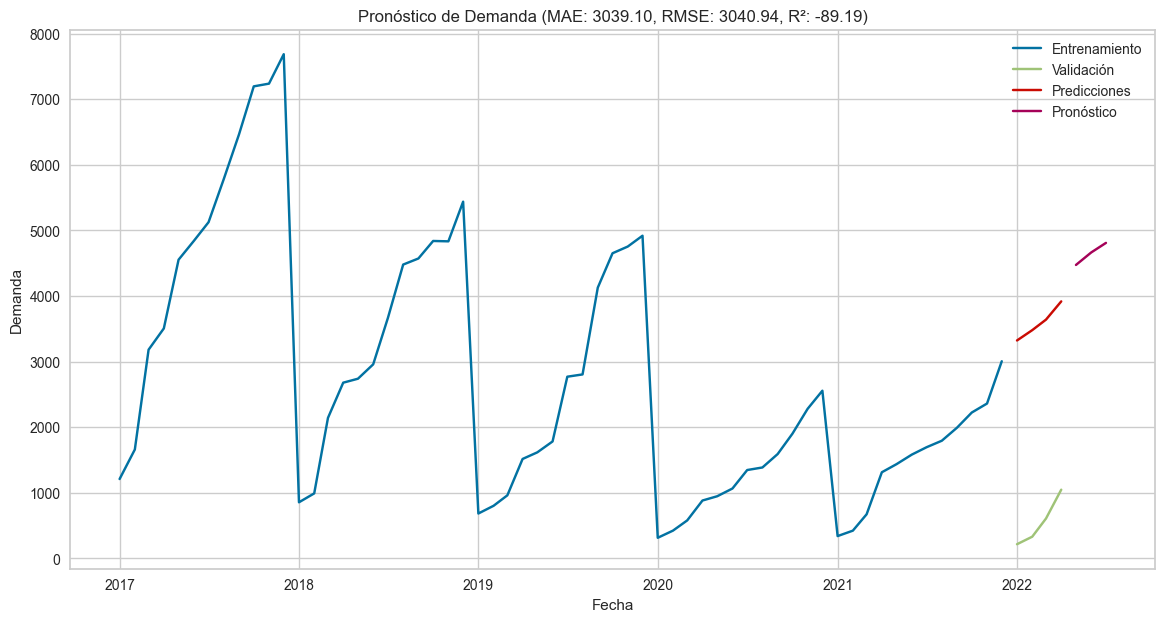

In [3]:
# Verificar datos nulos y realizar el preprocesamiento necesario
demand_data = demand_data.dropna()
alpha_beta_data = alpha_beta_data.dropna()
to_predict_data = to_predict_data.dropna()

# Visualizar la demanda histórica
demand_data.plot(figsize=(10, 6))
plt.title('Demanda Histórica')
plt.xlabel('Fecha')
plt.ylabel('Demanda')
plt.show()

# División de los datos en entrenamiento y validación
train_data = demand_data[:'2021-12']
valid_data = demand_data['2022-01':]

# Ajustar el modelo SARIMA
model = SARIMAX(train_data['Demand'], order=(1, 1, 1), seasonal_order=(1, 2, 2, 4))
model_fit = model.fit(disp=False)

# Pronóstico
forecast = model_fit.predict(start='2022-05', end='2022-07')

# Evaluación del modelo
predictions = model_fit.predict(start=valid_data.index[0], end=valid_data.index[-1])
mae = mean_absolute_error(valid_data['Demand'], predictions)
rmse = np.sqrt(mean_squared_error(valid_data['Demand'], predictions))
r2 = r2_score(valid_data['Demand'], predictions)

# Guardar los resultados en un archivo CSV
to_predict_data['Demand'] = forecast.values
to_predict_data.to_csv('predicted_demand.csv', index=False)


# Visualización de los resultados
plt.figure(figsize=(14, 7))
plt.plot(train_data.index, train_data['Demand'], label='Entrenamiento')
plt.plot(valid_data.index, valid_data['Demand'], label='Validación')
plt.plot(predictions.index, predictions, label='Predicciones')
plt.plot(forecast.index, forecast, label='Pronóstico')
plt.legend(loc='best')
plt.title(f'Pronóstico de Demanda (MAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.2f})')
plt.xlabel('Fecha')
plt.ylabel('Demanda')
plt.show()

Entrenar el modelo de clasificación

In [4]:
print(alpha_beta_data.head())


       autoID  SeniorCity Partner Dependents Service1          Service2  \
0  7590-VHVEG           0     Yes         No       No  No phone service   
1  5575-GNVDE           0      No         No      Yes                No   
2  3668-QPYBK           0      No         No      Yes                No   
3  7795-CFOCW           0      No         No       No  No phone service   
4  9237-HQITU           0      No         No      Yes                No   

  Security OnlineBackup DeviceProtection TechSupport        Contract  \
0       No          Yes               No          No  Month-to-month   
1      Yes           No              Yes          No        One year   
2      Yes          Yes               No          No  Month-to-month   
3      Yes           No              Yes         Yes        One year   
4       No           No               No          No  Month-to-month   

  PaperlessBilling              PaymentMethod  Charges   Demand  Class  
0              Yes           Electronic che

In [5]:
print(alpha_beta_data.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   autoID            7043 non-null   object 
 1   SeniorCity        7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   Service1          7043 non-null   object 
 5   Service2          7043 non-null   object 
 6   Security          7043 non-null   object 
 7   OnlineBackup      7043 non-null   object 
 8   DeviceProtection  7043 non-null   object 
 9   TechSupport       7043 non-null   object 
 10  Contract          7043 non-null   object 
 11  PaperlessBilling  7043 non-null   object 
 12  PaymentMethod     7043 non-null   object 
 13  Charges           7043 non-null   float64
 14  Demand            7043 non-null   object 
 15  Class             7043 non-null   object 
dtypes: float64(1), int64(1), object(14)
memory

In [6]:
print(alpha_beta_data.describe())

        SeniorCity      Charges
count  7043.000000  7043.000000
mean      0.162147    64.761692
std       0.368612    30.090047
min       0.000000    18.250000
25%       0.000000    35.500000
50%       0.000000    70.350000
75%       0.000000    89.850000
max       1.000000   118.750000


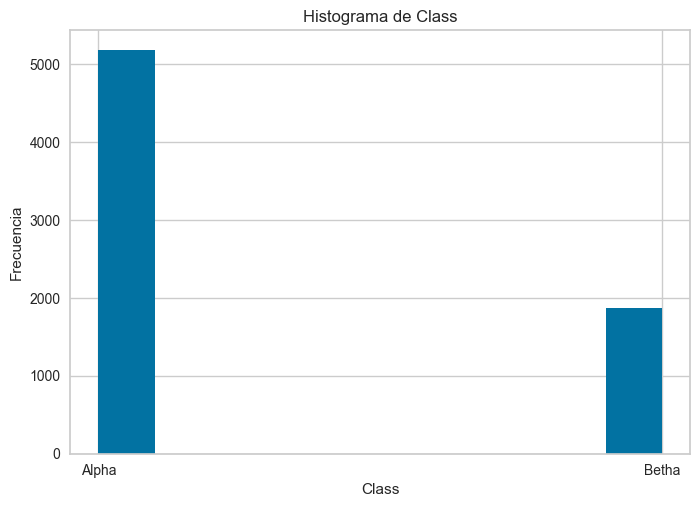

In [7]:
# Graficando el histograma para la columna 'class'
alpha_beta_data['Class'].hist()

# Añadiendo título y etiquetas
plt.title('Histograma de Class')
plt.xlabel('Class')
plt.ylabel('Frecuencia')

# Mostrando el gráfico
plt.show()

In [8]:

# Selección de características y etiquetas
X = alpha_beta_data.drop(['autoID', 'Class'], axis=1)
y = alpha_beta_data['Class']

# Convertir variables categóricas a numéricas
X = pd.get_dummies(X, drop_first=True)

# División de los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Escalado de características
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Balanceo de datos opcional (usando SMOTE)
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train_scaled, y_train)

# 2. Entrenar el Modelo (usando Grid Search)
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [20, 30, 40],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train_res, y_train_res)

# Mejor modelo encontrado por Grid Search
best_model = grid_search.best_estimator_

# 3. Evaluar el Modelo
y_pred = best_model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Guardar las métricas en un archivo .txt
with open('model_metrics.txt', 'w') as f:
    f.write(f"Modelo utilizado: RandomForestClassifier\n")
    f.write(f"Cantidad de datos de entrenamiento: {X_train.shape[0]}\n")
    f.write(f"Cantidad de datos de testeo: {X_test.shape[0]}\n")
    f.write(f"Accuracy: {accuracy:.2f}\n")
    f.write("Classification Report:\n")
    f.write(report)
    f.write("Confusion Matrix:\n")
    f.write(np.array2string(conf_matrix))

# 4. Guardar el Modelo entrenado
joblib.dump(best_model, 'trained_model.pkl')

# Guardar el escalador para su uso posterior en el servicio
joblib.dump(scaler, 'scaler.pkl')


Fitting 3 folds for each of 81 candidates, totalling 243 fits


['scaler.pkl']

In [ ]:
# Preprocesamiento
X = alpha_beta_data.drop(['autoID', 'Class'], axis=1)
y = alpha_beta_data['Class']

# Convertir variables categóricas a numéricas
data = pd.get_dummies(alpha_beta_data.drop(['Class'], axis=1), drop_first=True)

# Unir X y y para que PyCaret pueda procesarlo
data['Class'] = y

# Configurar PyCaret
clf = setup(data, target='Class', session_id=42, preprocess=True)

# Comparar todos los modelos
best_model = compare_models()

# Crear un modelo específico, por ejemplo, RandomForestClassifier
rf_model = create_model('rf')

# Entrenar el modelo
rf_model = tune_model(rf_model)

# Evaluar el modelo
evaluate_model(rf_model)

# Hacer predicciones
predictions = predict_model(rf_model)
print(predictions)

In [ ]:
clf = setup(data=data, target='Class', train_size=0.8, normalize=True, experiment_name='comparacion_modelos_2', fix_imbalance=True)

# Comparar los modelos
mejor_modelo = compare_models()

# Crear un modelo específico, por ejemplo, RandomForestClassifier
rf_modelo = create_model('rf')

# Entrenar el modelo
rf_modelo = tune_model(rf_modelo)

# Evaluar el modelo
evaluate_model(rf_modelo)

# Hacer predicciones
predicciones = predict_model(rf_modelo)
print(predicciones)

In [ ]:
# Preprocesamiento
X = alpha_beta_data.drop(['autoID', 'Class'], axis=1)
y = alpha_beta_data['Class']

# Convertir variables categóricas a numéricas
X = pd.get_dummies(X, drop_first=True)

# Dividir los datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Escalado de características
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Definir el modelo y los parámetros para GridSearchCV
model = RandomForestClassifier(random_state=42)
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Implementar GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train_scaled, y_train)

# Mejor modelo encontrado por GridSearchCV
best_model = grid_search.best_estimator_

# Evaluar el modelo
y_pred = best_model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

In [ ]:
# Preprocesamiento
X = alpha_beta_data.drop(['autoID', 'Class'], axis=1)
y = alpha_beta_data['Class']

# Convertir variables categóricas a numéricas
X = pd.get_dummies(X, drop_first=True)

# Dividir los datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Escalado de características
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Definir el modelo y los parámetros para GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'random_state': [42, 0, None]  # Variar random_state en la búsqueda
}

# Implementar GridSearchCV
grid_search = GridSearchCV(estimator=RandomForestClassifier(class_weight='balanced'), param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train_scaled, y_train)

# Mejor modelo encontrado por GridSearchCV
best_model = grid_search.best_estimator_

# Evaluar el modelo
y_pred = best_model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

# Imprimir las métricas en la consola
print(f'Best Parameters: {grid_search.best_params_}')
print(f'Accuracy: {accuracy}')
print('Classification Report:')
print(report)